# First Lab Assignment: WUM


## Dataset  
A random sample from the Central Statistical Office of Poland’s “Structure of Wages and Salaries by Occupations” (SWS) database (October 2010). This covers non-financial entities with more than nine employees. Earnings data are reported by corporate accounting and include both pay components and key employee/firm characteristics.

**Available variables:**  
- **id** – observation ID  
- **base** – total base salary  
- **bonus** – statutory and discretionary bonuses  
- **overtime_pay** – pay for overtime hours  
- **other** – additional/remuneration forms (profit–sharing, annual public-sector top-ups, etc.)  
- **sector** – economic sector (1=public, 2=private)  
- **section_07** – NACE section (1=Public Admin & Defence; 2=Education; 3=Health & Social Work)  
- **sex** – employee gender (1=male, 2=female)  
- **education** – highest degree (1=doctorate … 6=middle school or below)  
- **contract** – contract type (1=indefinite, 2=definite)  
- **age** – age in 2010  
- **duration_total** – total tenure  
- **duration_entity** – tenure in current entity  
- **duration_nominal** – hours actually worked  
- **duration_overtime** – overtime hours worked  

## Assignment Tasks

1. **Data Description**  
2. **Clustering**  
3. **Classification**  
4. **Regression**  

In [7]:
# — Installations —
%pip install --upgrade pip
%pip install numpy pandas scipy statsmodels matplotlib seaborn scikit-learn

# — Imports —
import numpy as np
import pandas as pd

from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_validate
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler,
    Normalizer, PowerTransformer, OneHotEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    mean_squared_error, r2_score,
    classification_report, confusion_matrix, accuracy_score,
    silhouette_score
)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1.a Missing Data and Variable Summary

Load the dataset, identify and treat zeros in key categorical and ordinal columns as missing, and report:

- Total number of observations  
- Number of rows with at least one missing value  
- Counts of zero entries by column  
- Overview of variable types: quantitative, qualitative, and ordinal


In [8]:
# Load data
df = pd.read_csv('earnings.csv', sep=';')

# Summary of observations
total_obs = len(df)

# Treat zeros as missing in these columns
cols_to_check = ['sector','section_07','sex','education','contract']
zero_counts   = (df[cols_to_check] == 0).sum()
df[cols_to_check] = df[cols_to_check].replace(0, pd.NA)

# Count rows with any missing value
missing_obs = df.isna().any(axis=1).sum()

print(f"Total observations: {total_obs}")
print(f"Zero counts per column:\n{zero_counts}")
print(f"Rows with missing data: {missing_obs}")
print("Quantitative variables: base, bonus, overtime_pay, other, age, duration_total, duration_entity, duration_nominal, duration_overtime")
print("Qualitative variables: sector, section_07, sex, contract")
print("Ordinal variable: education")


Total observations: 11000
Zero counts per column:
sector        0
section_07    0
sex           0
education     0
contract      0
dtype: int64
Rows with missing data: 0
Quantitative variables: base, bonus, overtime_pay, other, age, duration_total, duration_entity, duration_nominal, duration_overtime
Qualitative variables: sector, section_07, sex, contract
Ordinal variable: education


## 1.b Descriptive Statistics for Quantitative Variables

Compute basic summary statistics (count, mean, standard deviation, min, quartiles, max) for all numerical features to understand their distributions and scales.


In [9]:
# Define variable groups
quantitative = [
    'base', 'bonus', 'overtime_pay', 'other',
    'age', 'duration_nominal', 'duration_overtime'
]
qualitative = ['sector', 'section_07', 'sex', 'education', 'contract']

# Display descriptive statistics for quantitative features
df[quantitative].describe().T

,count,mean,std,min,25%,50%,75%,max
base,11000.0,33376.738065,19276.551638,10.0,20995.115,31341.245,41348.2900,241624.39
bonus,11000.0,2128.486176,4966.444726,0.0,0.000,620.000,2940.7175,258061.00
overtime_pay,11000.0,1679.273923,5407.964344,0.0,0.000,0.000,1139.3300,228110.34
other,11000.0,2477.625815,3715.419120,0.0,0.000,2141.820,3497.4300,88555.76
age,11000.0,42.470182,10.012140,19.0,34.000,43.000,51.0000,77.00
duration_nominal,11000.0,1301.307435,540.189234,12.8,766.800,1591.900,1768.0000,2024.00
duration_overtime,11000.0,47.702325,111.963867,0.0,0.000,0.000,40.0000,1812.58


## 1.b Frequency Tables for Qualitative Variables

For each categorical feature (`sector`, `section_07`, `sex`, `education`, `contract`), we compute and display a table showing the count and percentage of observations in each category. This gives insight into the distribution of employees across these groups.


In [10]:
# Frequency tables for qualitative features
for col in qualitative:
    counts   = df[col].value_counts(dropna=False)
    percents = df[col].value_counts(normalize=True, dropna=False) * 100
    table = pd.DataFrame({
        'Category':        counts.index,
        'Count':           counts.values,
        'Percentage (%)':  percents.round(2).values
    })
    print(f"\n{col} frequency table:")
    print(table.to_string(index=False))



sector frequency table:
 Category  Count  Percentage (%)
        1  10548           95.89
        2    452            4.11

section_07 frequency table:
 Category  Count  Percentage (%)
        2   5867           53.34
        3   2732           24.84
        1   2401           21.83

sex frequency table:
 Category  Count  Percentage (%)
        2   8289           75.35
        1   2711           24.65

education frequency table:
 Category  Count  Percentage (%)
        2   6633           60.30
        4   1983           18.03
        5    906            8.24
        3    680            6.18
        1    430            3.91
        6    368            3.35

contract frequency table:
 Category  Count  Percentage (%)
        1   9306            84.6
        2   1694            15.4


### 1.c Exploratory Data Analysis

**1. Quantitative Variables**  
Plot histograms with overlaid normal density curves to check distribution shape, mean (μ) and standard deviation (σ).

**2. Qualitative Variables**  
Plot bar charts of category counts (including `education`) to visualize frequency distribution.


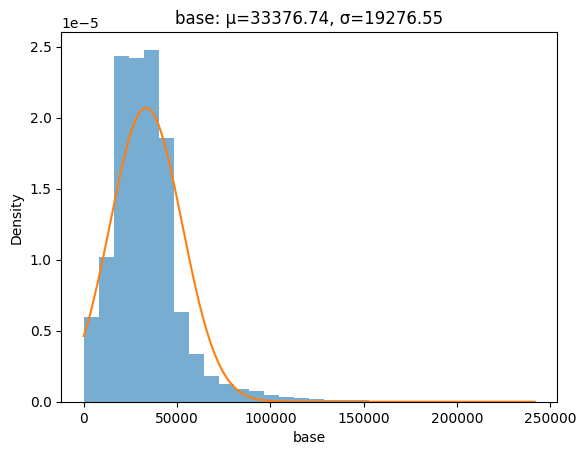

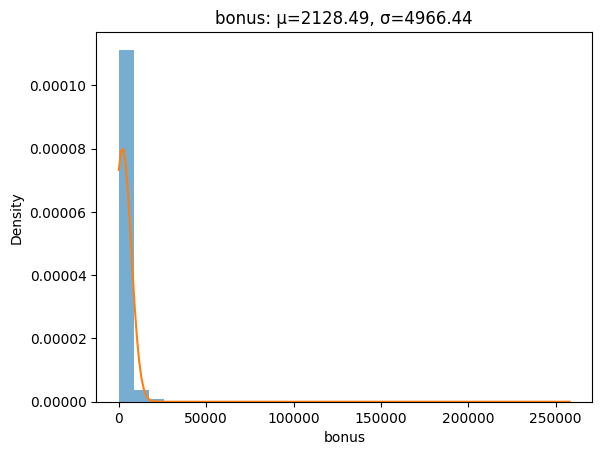

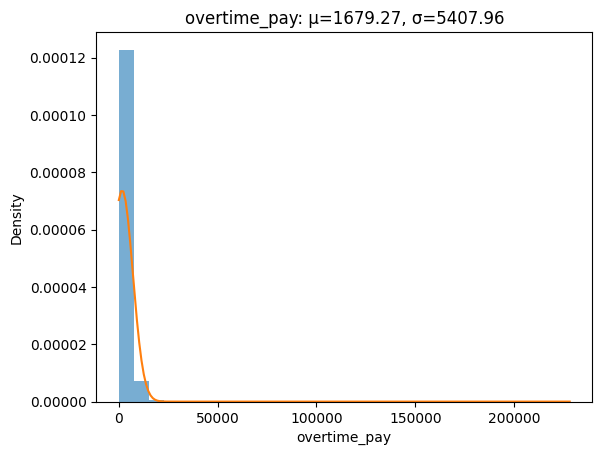

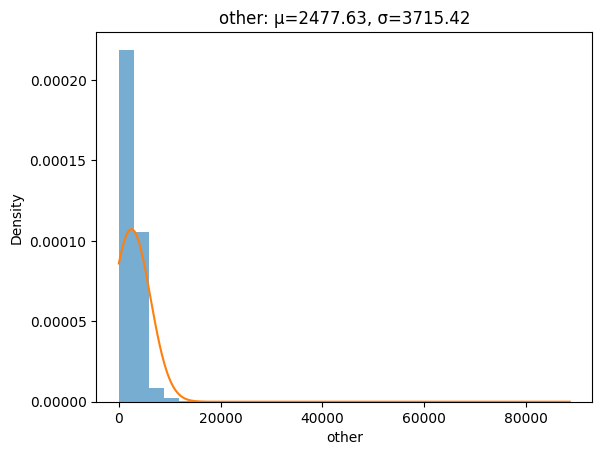

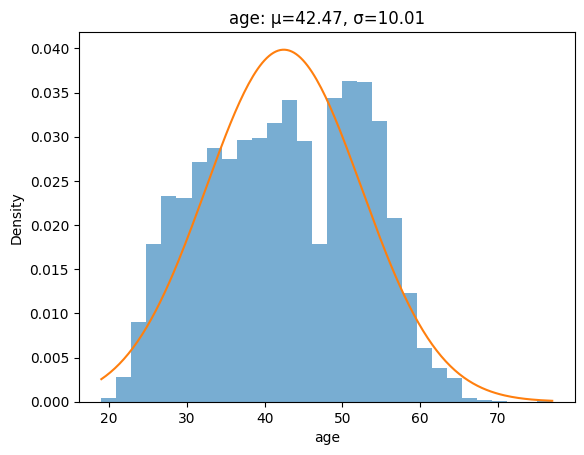

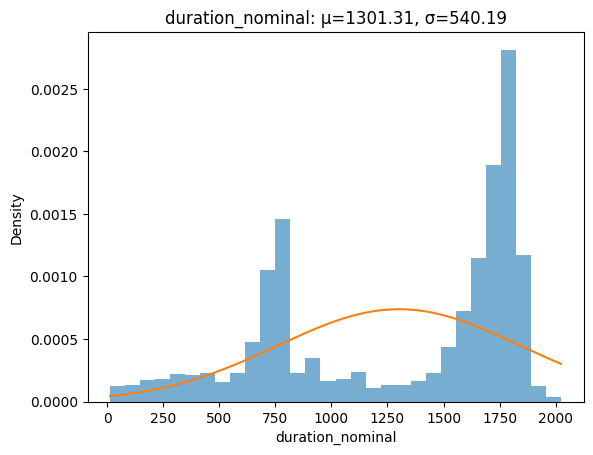

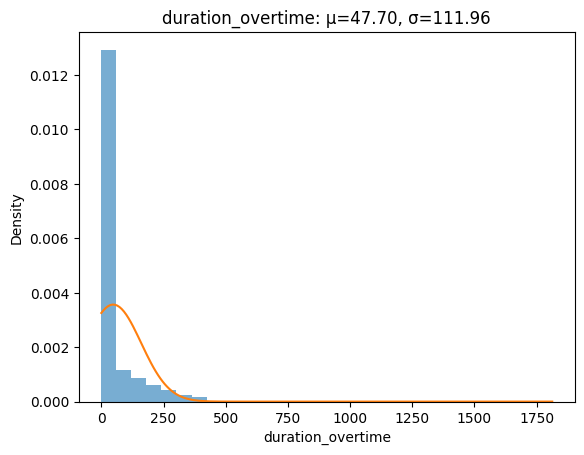

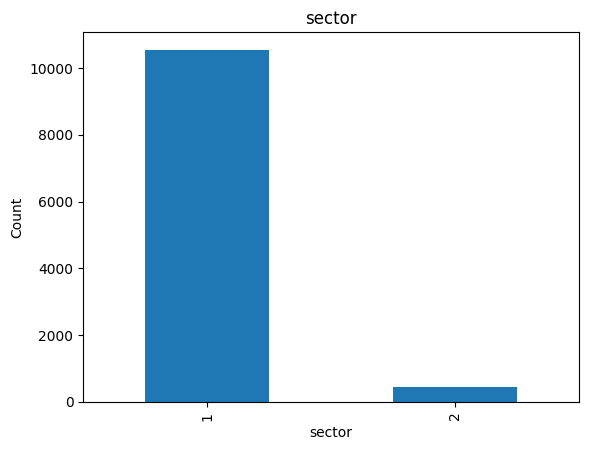

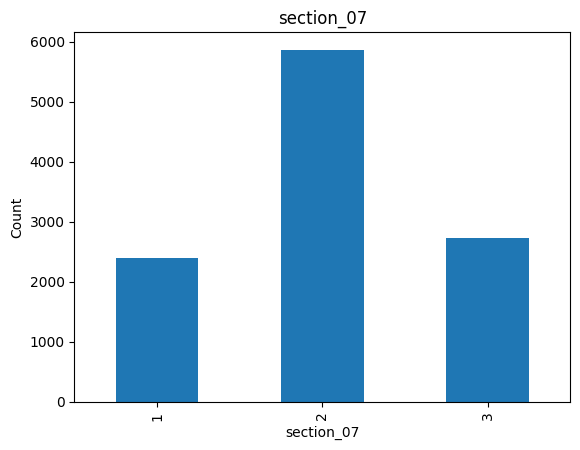

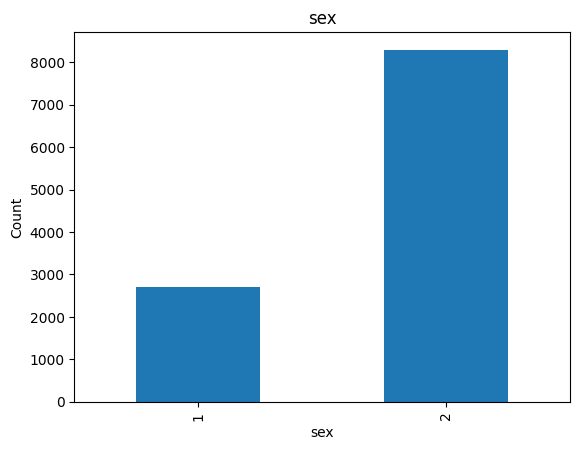

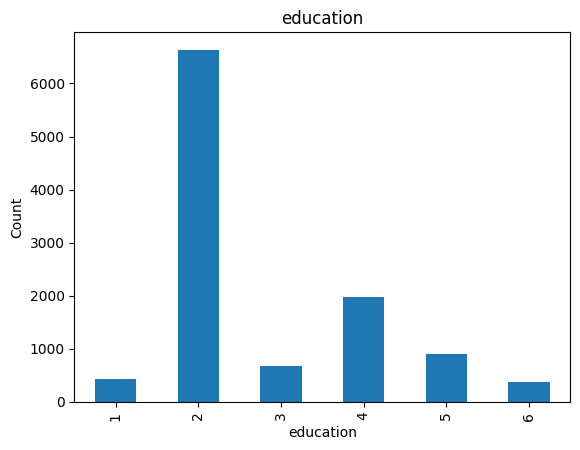

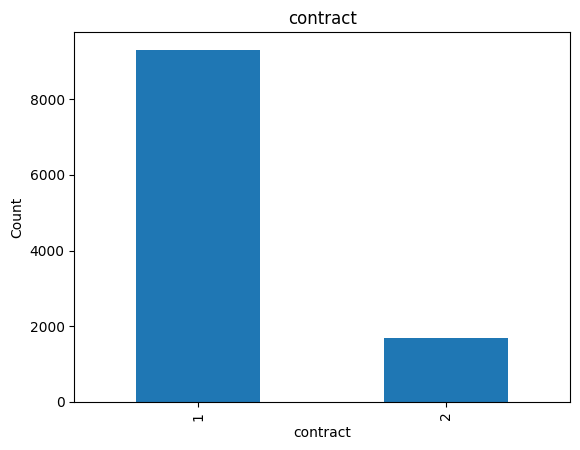

In [11]:
# 1) Histograms with Normal overlay
for var in quantitative:
    data = df[var].dropna()
    mu, sigma = data.mean(), data.std()
    
    plt.hist(data, bins=30, density=True, alpha=0.6)
    x = np.linspace(data.min(), data.max(), 200)
    pdf = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-((x-mu)**2)/(2*sigma**2))
    plt.plot(x, pdf)
    plt.title(f'{var}: μ={mu:.2f}, σ={sigma:.2f}')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.show()

# 2) Bar charts for qualitative variables
for var in qualitative:
    counts = df[var].value_counts(dropna=False).sort_index()
    counts.plot(kind='bar')
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.show()

# Employee Segmentation by Hourly Compensation

## 1. Feature Engineering
- **Calculation**:  
  `hour_salary = (base + bonus + overtime_pay) / (duration_nominal + duration_overtime)`
- **Goal**:  
  - Unify multiple pay components into a single hourly rate.  
  - Facilitate comparisons across employees with different compensation structures.
- **Benefits**:  
  - Reduces raw feature redundancy.  
  - Improves interpretability and consistency.

---

## 2. Variable Selection
- **Dropped**:  
  - `id` (identifier)  
  - `base`, `bonus`, `overtime_pay` (replaced by `hour_salary`)  
  - `duration_nominal`, `duration_overtime`, `duration_total`, `duration_entity` (redundant)  
  - `sector`, `education` (assumed less relevant for pay-based segmentation)
- **Retained**:  
  - Numeric features: `hour_salary`, `other`, `age`  
  - Categorical features: `section_07`, `sex`, `contract`

---

## 3. Preprocessing
1. **Numeric scaling**  
   - Method: MaxAbsScaler  
   - Effect: Scales values to \[-1, 1\], preserving sparsity and zero-centered symmetry.
2. **Categorical encoding**  
   - Method: OneHotEncoder with `drop='if_binary'`  
   - Effect: Creates binary columns for each category, removes redundant column for binary variables.

---

## 4. Clustering Method: Hierarchical (Ward)
- **Algorithm**: Agglomerative Clustering with `linkage='ward'`  
- **Advantages**:  
  - Minimizes within-cluster variance.  
  - Produces a dendrogram for visualizing cluster merges.
- **Number of clusters (k = 10)**:  
  - Balances granularity and practical usability.  
  - Can be validated with dendrogram analysis or “silhouette vs. k” plots.

---

## 5. Cluster Evaluation
- **Metric**: Silhouette Score  
  - Range: \[0, 1\]  
  - Higher values indicate better-defined, well-separated clusters.

---

## 6. Cluster Profiling
- **Cluster sizes**: Count of observations per cluster.  
- **Centroids**: Mean values of `hour_salary`, `other`, `age` for each cluster.

---

## Summary
1. **MaxAbsScaler** – stable, zero-centered scaling.  
2. **OneHotEncoder** – clear representation of categorical data.  
3. **Ward linkage** – variance-minimizing hierarchical clustering.  
4. **k = 10** – practical number of segments.  
5. **Silhouette Score** – quick assessment of cluster quality.  


In [12]:
# 1. Compute hourly salary and select features
df = df.assign(
    hour_salary=(df['base'] + df['bonus'] + df['overtime_pay'])
                / (df['duration_nominal'] + df['duration_overtime'])
)
X = df.drop(columns=[
    'id', 'base', 'bonus', 'overtime_pay',
    'duration_overtime', 'duration_nominal',
    'duration_total', 'duration_entity',
    'sector', 'education'
])

# 2. Define preprocessing pipeline
numeric_cols = ['hour_salary', 'other', 'age']
categorical_cols = ['section_07', 'sex', 'contract']
preprocessor = ColumnTransformer([
    ('num', MaxAbsScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary'), categorical_cols)
], sparse_threshold=0)

X_proc = preprocessor.fit_transform(X)

# 3. Perform hierarchical clustering
clusterer = AgglomerativeClustering(n_clusters=10, linkage='ward')
labels = clusterer.fit_predict(X_proc)

# 4. Evaluate clustering
score = silhouette_score(X_proc, labels)
print(f"Silhouette score: {score:.4f}")

counts = pd.Series(labels).value_counts().sort_index()
print("Cluster sizes:")
print(counts.to_string())

# 5. Compute cluster centroids for numeric features
df_centroids = df[numeric_cols].copy()
df_centroids['cluster'] = labels
centroids = df_centroids.groupby('cluster')[numeric_cols].mean().round(3)
print("Cluster centroids:")
print(centroids)

Silhouette score: 0.8107
Cluster sizes:
0     479
1    3692
2     197
3    1864
4    1537
5     667
6     685
7     389
8     333
9    1157
Cluster centroids:
         hour_salary     other     age
cluster                               
0             20.327   401.314  36.651
1             36.972  3061.070  43.231
2             21.493  2225.724  32.528
3             22.757   567.530  44.247
4             27.370  2940.153  41.927
5             31.395  3602.536  43.718
6             29.258  2039.595  35.686
7             29.032   660.133  44.668
8             31.043  2932.525  40.144
9             35.698  4072.158  45.230


# Task Objective
- **Goal**: Using the classification methods we have discussed, build a model that predicts whether an employee has a higher-education degree (`education ≤ 2`) based on the other available features.
- **Secondary Goal**: Evaluate the relative importance of different variables in the model you have constructed.

## Why K-Nearest Neighbors (KNN)?
- **Simplicity & Interpretability**: KNN makes predictions based on the closest training samples in feature space—easy to understand and explain.
- **Non-parametric**: It makes no strong assumptions about the underlying data distribution (unlike e.g. logistic regression).
- **Adaptable Decision Boundaries**: By adjusting the number of neighbors k, we can control model complexity and smoothness of decision regions.

---
## Results:

1. Cross-Validation Assessment
   - SETUP StratifiedKFold (5 splits, shuffle)
   - SPECIFY metrics: accuracy, precision, recall, F1
   - RUN cross_validate on full dataset with tuned pipeline
   - COMPUTE mean ± std for each metric

   >> CV (mean ± std):
      accuracy : 0.864 ± 0.009
      precision: 0.900 ± 0.008
      recall   : 0.887 ± 0.009
      f1       : 0.893 ± 0.007

2. Test-Set Evaluation
   - FIT pipeline on training data
   - PREDICT on test set
   - CALCULATE & DISPLAY:
       * Test accuracy: 0.853
       * Classification report:
         - ed>2  precision:0.78, recall:0.81, f1:0.80, support:1181
         - ed≤2  precision:0.89, recall:0.88, f1:0.88, support:2119
       * Confusion matrix:
         [[960 221]
          [264 1855]]

3. Feature Importance
   - APPLY permutation_importance on test set
   - COMPUTE mean importance over repeats
   - SORT and DISPLAY top 10 features:
     duration_nominal     0.0838  
     base                 0.0827  
     duration_total       0.0304  
     age                  0.0229  
     other                0.0187  
     section_07_2         0.0182  
     duration_entity      0.0165  
     section_07_3         0.0157  
     bonus                0.0058  
     duration_overtime    0.0053  

   - Key drivers:
     * duration_nominal and base pay are the strongest predictors of education level.
     * Total hours, age, and other income also significantly influence the classification.
     * Section indicators contribute to differentiation but with smaller effects.


In [5]:
from sklearn.inspection import permutation_importance
# 1. Load & prepare data
df = pd.read_csv('earnings.csv', sep=';', engine='python')
df['target'] = (df['education'] <= 2).astype(int)
df = df.drop(columns=['id', 'education'])
df.columns = (
    df.columns
      .str.lower()
      .str.replace(' ', '_')
      .str.replace('-', '_')
)
df = pd.get_dummies(
    df,
    columns=['sector', 'section_07', 'sex', 'contract'],
    drop_first=True
)

# 2. Split into train/test
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.3,
    random_state=42
)

# 3. Tune k with GridSearchCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
param_grid = {'knn__n_neighbors': range(1, 21)}
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train, y_train)
best_k = grid.best_params_['knn__n_neighbors']

# set the best k
pipeline.set_params(knn__n_neighbors=best_k)

# 4. Cross-validation on full data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_res = cross_validate(
    pipeline, X, y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

print("CV (mean ± std):")
for m in scoring:
    mean = cv_res[f'test_{m}'].mean()
    std = cv_res[f'test_{m}'].std()
    print(f"  {m}: {mean:.3f} ± {std:.3f}")

# 5. Final evaluation on the test set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f"\nTest accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=['ed>2','ed≤2']))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

# 6. Permutation importance
perm = permutation_importance(
    pipeline,
    X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
top10 = (
    pd.Series(perm.importances_mean, index=X.columns)
      .nlargest(10)
)
print("\nTop 10 feature importances:")
print(top10)

CV (mean ± std):
  accuracy: 0.864 ± 0.009
  precision: 0.900 ± 0.008
  recall: 0.887 ± 0.009
  f1: 0.893 ± 0.007

Test accuracy: 0.853

Classification report:
              precision    recall  f1-score   support

        ed>2       0.78      0.81      0.80      1181
        ed≤2       0.89      0.88      0.88      2119

    accuracy                           0.85      3300
   macro avg       0.84      0.84      0.84      3300
weighted avg       0.85      0.85      0.85      3300


Confusion matrix:
[[ 960  221]
 [ 264 1855]]

Top 10 feature importances:
duration_nominal     0.083788
base                 0.082697
duration_total       0.030394
age                  0.022939
other                0.018697
section_07_2         0.018242
duration_entity      0.016515
section_07_3         0.015667
bonus                0.005758
duration_overtime    0.005273
dtype: float64


# Task Objective
- Build a regression model to predict base salary using available features.
- Split data appropriately into training and testing subsets.
- Exclude unnecessary variables to simplify the model.
- Discuss the role (positive or negative) of each variable in the final model.

## Why OLS Regression?
- **Interpretability**: Provides direct estimates of each feature’s effect on base salary.
- **Transparent Variable Roles**: Coefficients indicate positive or negative impacts.
- **Baseline Benchmark**: Simple linear model to compare against more complex methods.

---

# Pseudocode Workflow

1. Load & Clean Data
   - LOAD 'earnings.csv'
   - SET y = base salary column
   - DROP columns: id, base, section_07, duration_overtime, sector
   - NORMALIZE column names (lowercase, underscores)

2. Encode & Scale Features
   - ONE-HOT ENCODE: sex, contract (drop first level)
   - DEFINE numeric features:
       bonus, overtime_pay, other, age,
       duration_total, duration_entity, duration_nominal
   - APPLY StandardScaler to numeric features

3. Train/Test Split
   - SPLIT X, y into training (70%) and test (30%) sets with random_state=42

4. Fit OLS Model
   - ADD constant term to X_train, X_test
   - FIT OLS regression on training data
   - OUTPUT model summary (R², coefficients, p-values)

5. Evaluate Model
   - PREDICT base salary on X_test
   - CALCULATE Test RMSE and Test R²
   - DISPLAY performance metrics

6. Variable Roles (Coefficient Signs)
   - const            : intercept baseline
   - bonus            : **positive** (higher bonus → higher base)
   - overtime_pay     : **positive**
   - other            : **positive**
   - education        : **negative** (higher education code → lower base)
   - age              : **positive**
   - duration_total   : **positive**
   - duration_entity  : **positive**
   - duration_nominal : **positive**
   - sex_2            : **negative** (being category “2” → lower base)
   - contract_2       : **negative**

7. Conclusions
   - Model explains ~47.6% of variance (Adj. R² ≈ 0.476).
   - Key positive drivers: duration_nominal, other pay components, age.
   - Negative effects: higher education code, certain sex/contract categories.
   - RMSE ≈ 13,831; Test R² ≈ 0.468 indicates moderate predictive power.


In [6]:
# 1. Load & clean
df = pd.read_csv('earnings.csv', sep=';', engine='python')
y  = df['base']
X  = df.drop(columns=['id','base','section_07','duration_overtime','sector'])
X.columns = X.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

# 2. Encode & scale
X = pd.get_dummies(X, columns=['sex','contract'], drop_first=True)
num_feats = ['bonus','overtime_pay','other','age','duration_total','duration_entity','duration_nominal']
X[num_feats] = StandardScaler().fit_transform(X[num_feats])

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Fit OLS
X_train_sm = sm.add_constant(X_train).astype(float)
X_test_sm  = sm.add_constant(X_test).astype(float)
y_train    = y_train.astype(float)
ols_model  = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

# 5. Evaluate
y_pred = ols_model.predict(X_test_sm)
rmse   = np.sqrt(mean_squared_error(y_test, y_pred))
r2     = r2_score(y_test, y_pred)
print(f"\nTest RMSE: {rmse:.2f}")
print(f"Test R²:   {r2:.3f}")

                            OLS Regression Results                            
Dep. Variable:                   base   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     700.3
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        11:05:05   Log-Likelihood:                -84457.
No. Observations:                7700   AIC:                         1.689e+05
Df Residuals:                    7689   BIC:                         1.690e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5.703e+04    538.433  